In [1]:
#################################################
#created the 17/05/2018 14:14 by Alexis Blanchet#
#################################################
#-*- coding: utf-8 -*-
'''

'''

'''
Améliorations possibles:

'''
import warnings
warnings.filterwarnings('ignore')
#################################################
###########        Imports      #################
#################################################
import sys
import numpy as np
import pandas as pd
import scipy.stats
import plotly
import plotly.graph_objs as go
import plotly.offline as offline
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasClassifier
#################################################
########### Global variables ####################
#################################################
fileX_train1 ='/home/alexis/Bureau/Stage/ProgrammesTV/merged_2018-04-30.csv'
fileX_train2 ='/home/alexis/Bureau/Stage/ProgrammesTV/merged_2018-05-18.csv'
fileX_train3 ='/home/alexis/Bureau/Stage/ProgrammesTV/merged_2018-05-23.csv'
fileX_valid ='/home/alexis/Bureau/Stage/ProgrammesTV/merged_2018-05-09.csv'
fileX_test ='/home/alexis/Bureau/Stage/ProgrammesTV/merged_2018-05-07.csv'
#################################################
########### Important functions #################
#################################################
def load(fileX):
    df = pd.read_csv(fileX)
    df = df.drop(['heure','CP','RESUME','DIFFERE','PT1','INEDIT_EN_CLAIR','OCCULTATIONMOBILE','DATE','PREMDIF','SOUSTITREDIF','TITREEMISSION'],axis=1)
    y = df['label']
    return df.drop(['label'],axis=1),y




Using TensorFlow backend.


In [2]:
X_train1,y_train1 = load(fileX_train1)
X_train2,y_train2 = load(fileX_train2)
X_train3,y_train3 = load(fileX_train3)
X_valid,y_valid = load(fileX_valid)
X_test,Y_test = load(fileX_test)


In [3]:
X = pd.concat([X_train1,X_train2,X_train3,X_valid])
y = pd.concat([y_train1,y_train2,y_train3,y_valid])
X.head()

,minutes,isinprogramme,debut,fin,TITRE,STEREO,DOLBY51,DIRECT,NOUVEAUTE,PT3,...,STM,VM,HD,CLE-GENRE,description programme,DERDIF,INEDIT_CRYPTE,temps depuis debut,temps avant fin,pourcentage déjà vu
0,389,1,385,505,TFou,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,403.0,Magazine jeunesse,0.0,0.0,4.0,116.0,0.033333
1,390,1,385,505,TFou,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,403.0,Magazine jeunesse,0.0,0.0,5.0,115.0,0.041667
2,431,1,385,505,TFou,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,403.0,Magazine jeunesse,0.0,0.0,46.0,74.0,0.383333
3,443,1,385,505,TFou,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,403.0,Magazine jeunesse,0.0,0.0,58.0,62.0,0.483333
4,444,1,385,505,TFou,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,403.0,Magazine jeunesse,0.0,0.0,59.0,61.0,0.491667


In [4]:
len(X)

355

In [5]:
from sklearn import preprocessing

X_tot = pd.concat([X,X_test])
l = len(X)

for f in X_tot.columns: 
    if X_tot[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder() 
        lbl.fit(list(X_tot[f].values)) 
        X_tot[f] = lbl.transform(list(X_tot[f].values))


X = X_tot[0:l]
X_test = X_tot[l:]


In [6]:
X.shape

(355, 29)

In [7]:
X_test.shape

(94, 29)

In [36]:
### XGB modeling
params = {'eta': 0.001,
          'max_depth': 6, 
          'subsample': 0.9, 
          'colsample_bytree': 1, 
          'colsample_bylevel':1,
          'min_child_weight':1,
          'alpha':0,
          'objective': 'multi:softprob',
          'eval_metric': 'mlogloss',
          'seed': 99,
          'silent': 1,
         'num_class' : 3,
         }
params2 = {'eta': 0.001,
          'max_depth': 6, 
          'subsample': 0.9, 
          'colsample_bytree': 0.9, 
          'colsample_bylevel':0.9,
          'min_child_weight':0.9,
          'alpha':0.01,
          'objective': 'multi:softprob',
          'eval_metric': 'mlogloss',
          'seed': 42,
          'silent': 1,
          'num_class' : 3,
         }

######################################################
class Classifier(BaseEstimator):
    def __init__(self):
        pass
 
    def fit(self,X,y):
        np.random.seed(99)
        x1, x2, y1, y2 = train_test_split(X, y, test_size=0.2)
        watchlist = [(xgb.DMatrix(x1, y1, weight = [y*2+1 for y in y1]), 'train'), (xgb.DMatrix(x2, y2,weight = [y*2+1 for y in y2]), 'valid')]
        self.clf1 = xgb.train(params, (xgb.DMatrix(x1, y1, weight = [y*2+1 for y in y1])), 50000,  watchlist, maximize = False,verbose_eval=500, early_stopping_rounds=3000)
        self.clf2 = xgb.train(params2, (xgb.DMatrix(x1, y1, weight = [y*2+1 for y in y1])), 50000,  watchlist, maximize = False,verbose_eval=500, early_stopping_rounds=3000)
        
       
    def predict(self, X):
        return self.clf.predict(X)
 
    def predict_proba(self, X):
        res1 = self.clf1.predict(xgb.DMatrix(X), ntree_limit=self.clf1.best_ntree_limit)
        res2 = self.clf2.predict(xgb.DMatrix(X), ntree_limit=self.clf2.best_ntree_limit)
        return np.array([[(a[0]+b[0])/2,(a[1]+b[1])/2,(a[2]+b[2])/2] for a,b in zip(res1,res2)])
np.random.seed(7)
clf = Classifier()
clf.fit(X,y)

[0]	train-mlogloss:1.09754	valid-mlogloss:1.09783
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 3000 rounds.
[500]	train-mlogloss:0.7307	valid-mlogloss:0.834838
[1000]	train-mlogloss:0.533522	valid-mlogloss:0.705867
[1500]	train-mlogloss:0.416129	valid-mlogloss:0.63941
[2000]	train-mlogloss:0.340876	valid-mlogloss:0.605932
[2500]	train-mlogloss:0.290416	valid-mlogloss:0.592237
[3000]	train-mlogloss:0.254821	valid-mlogloss:0.590232
[3500]	train-mlogloss:0.227677	valid-mlogloss:0.597077
[4000]	train-mlogloss:0.205756	valid-mlogloss:0.608297
[4500]	train-mlogloss:0.18812	valid-mlogloss:0.622149
[5000]	train-mlogloss:0.173574	valid-mlogloss:0.637485
[5500]	train-mlogloss:0.161265	valid-mlogloss:0.654607
Stopping. Best iteration:
[2877]	train-mlogloss:0.262654	valid-mlogloss:0.589769

[0]	train-mlogloss:1.09757	valid-mlogloss:1.09787
Multiple eval metrics have been passed: 'valid-mlogloss' will b

In [45]:
y_score = clf.predict_proba(X_test)

In [39]:
from sklearn.base import BaseEstimator
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

#################################################
########### Global variables ####################
#################################################
class Classifier2(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X,y):
        x1, x2, y1, y2 = train_test_split(X, y, test_size=0.2, random_state=99)
        self.clf1 = CatBoostClassifier(iterations=5000,learning_rate=0.01, depth=6,metric_period = 50, loss_function='MultiClass', eval_metric='MultiClass', random_seed=99, od_type='Iter', od_wait=500,class_weights = [1,3,5])
        self.clf1.fit(x1,y1,verbose=True,eval_set=(x2,y2),use_best_model=True)
        self.clf2 = CatBoostClassifier(iterations=5000,learning_rate=0.01, depth=7,metric_period = 50, loss_function='MultiClass', eval_metric='MultiClass', random_seed=99, od_type='Iter', od_wait=500,class_weights = [1,3,5])
        self.clf2.fit(x1,y1,verbose=True,eval_set=(x2,y2),use_best_model=True)
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return np.array(np.array([[(a[0]+b[0])/2,(a[1]+b[1])/2,(a[2]+b[2])/2] for a,b in zip(self.clf2.predict_proba(X),self.clf1.predict_proba(X))]))

np.random.seed(7)
clf2 = Classifier2()
clf2.fit(X,y)

0:	learn: -1.0910473	test: -1.0912628	best: -1.0912628 (0)	total: 3.86ms	remaining: 19.3s
50:	learn: -0.8812984	test: -0.8803397	best: -0.8803397 (50)	total: 111ms	remaining: 10.8s
100:	learn: -0.7685689	test: -0.7671242	best: -0.7671242 (100)	total: 221ms	remaining: 10.7s
150:	learn: -0.7036904	test: -0.6965349	best: -0.6965349 (150)	total: 320ms	remaining: 10.3s
200:	learn: -0.6598346	test: -0.6533542	best: -0.6533542 (200)	total: 423ms	remaining: 10.1s
250:	learn: -0.6205314	test: -0.6131897	best: -0.6131897 (250)	total: 545ms	remaining: 10.3s
300:	learn: -0.5999037	test: -0.5949353	best: -0.5949353 (300)	total: 644ms	remaining: 10.1s
350:	learn: -0.5794074	test: -0.5787354	best: -0.5785951 (349)	total: 766ms	remaining: 10.1s
400:	learn: -0.5611264	test: -0.5660660	best: -0.5660660 (400)	total: 879ms	remaining: 10.1s
450:	learn: -0.5445753	test: -0.5544529	best: -0.5544529 (450)	total: 1.04s	remaining: 10.5s
500:	learn: -0.5298736	test: -0.5463360	best: -0.5463360 (500)	total: 1.21s

In [40]:
y_score2 = clf2.predict_proba(X_test)

In [41]:
y_tot = np.array([[(a[0]+b[0])/2,(a[1]+b[1])/2,(a[2]+b[2])/2] for a,b in zip(y_score,y_score2)])

In [46]:
def find_index(l,v):
    res = []
    for i, j in enumerate(l):
        if(j == v):
            res.append(i)
    return res    

def get_label(y_score):
    res = []
    for i in range(len(y_score)):
        if(y_score[i][1]>0.5):
            res.append(1)
        elif(y_score[i][0]>0.5):
            res.append(0)
        else:
            res.append(2)
    return res

def mesure_class(y_pred,y_true,j):
    TP = 0
    FP = 0
    FN = 0
    for i in range(len(y_pred)-1):
        i = i+1
        if(y_pred[i] == j):
            if(Y_test[i] == j):
                TP += 1
            else:
                FP += 1
    for i in range(len(y_true)-1):
        i = i+1
        if(y_true[i] == j):
            if(y_pred[i] == j):
                pass
            else:
                FN += 1
    return TP,FP,FN

def score(tp,fp,fn,epsilon=10**-5):
    beta = 2
    p = tp/(tp+fp+epsilon)
    r = tp/(tp+fn+epsilon)
    beta_squared = beta ** 2
    f = (beta_squared + 1) * (p * r) / (beta_squared * p + r+epsilon)
    
    print("|| precison: "+str(p)+"|| recall: "+str(r)+"|| fbeta: "+str(f))
    print('--------------------------------------------------')

def mesure(y_score=y_score,y_test=Y_test):
    y = get_label(y_score)
    TP1,FP1,FN1 = mesure_class(y,y_test,0)
    TP2,FP2,FN2 = mesure_class(y,y_test,1)
    TP3,FP3,FN3 = mesure_class(y,y_test,2)
    print("pour la classe 0")
    score(TP1,FP1,FN1)
    print("pour la classe 1")
    score(TP2,FP2,FN2)
    print("pour la classe 2")
    score(TP3,FP3,FN3)

print("tout")
mesure(y_tot,Y_test)
print("XGB")
mesure(y_score,Y_test)
print("CatBoost")
mesure(y_score2,Y_test)
    

tout
pour la classe 0
|| precison: 0.8333319444467593|| recall: 0.18518511659810497|| fbeta: 0.21929752616298662
--------------------------------------------------
pour la classe 1
|| precison: 0.7297295325055317|| recall: 0.7941174134948783|| fbeta: 0.7803444936406899
--------------------------------------------------
pour la classe 2
|| precison: 0.5999998800000239|| recall: 0.9374997070313414|| fbeta: 0.8426938675749825
--------------------------------------------------
XGB
pour la classe 0
|| precison: 0.7692301775152481|| recall: 0.37037023319620993|| fbeta: 0.4132217710570621
--------------------------------------------------
pour la classe 1
|| precison: 0.6829266627008139|| recall: 0.8235291695502441|| fbeta: 0.790958003772859
--------------------------------------------------
pour la classe 2
|| precison: 0.6666664957265395|| recall: 0.8124997460938292|| fbeta: 0.778440643270937
--------------------------------------------------
CatBoost
pour la classe 0
|| precison: 0.9999950

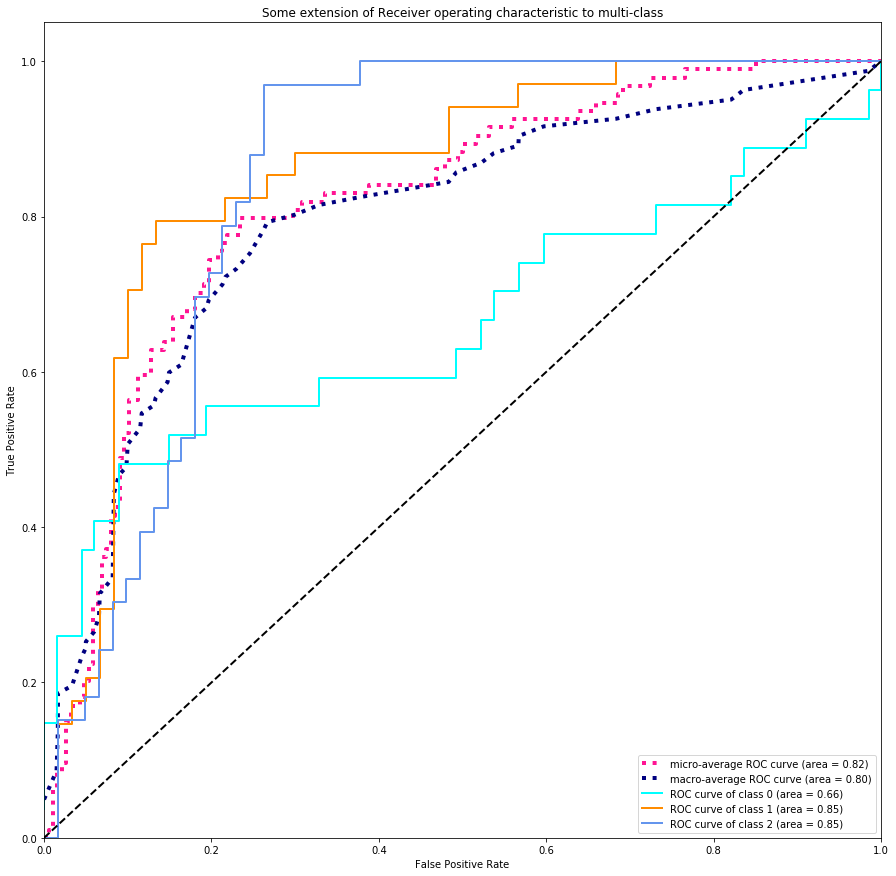

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

y_score = y_tot

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
y_test = label_binarize(Y_test, classes=[0, 1, 2])
n_classes = y_test.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15,15))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

    

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig('auc.png')
plt.show()
